<img align="top" width="250" height="70" src="https://s3.amazonaws.com/samples.clarifai.com/logo/clarifai_logo.png" alt="banner">

&nbsp;

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Clarifai/colab-notebooks/blob/main/search/visual_search.ipynb)

# General Information

This notebook is to be used to search images on the Clarifai Platform. In this tutorial, you will learn how to upload images with URLs and learn how to perform visual search over your inputs. 

Note that this has some overlap with the [basic_uploading](https://github.com/Clarifai/colab-notebooks/blob/main/uploading/basic_uploading.ipynb) tutorial.

## How to Run
You can run each code cell independently by using `SHIFT + ENTER`. You can also run the whole notebook (all cells) using `RUN ALL`.

## Expected inputs

- The app ID **(required)**
- The user ID **(required)**
- An PAT key token **(required)**

## Limitations

- Not meant for text search, but extending this to text search is easy.


# Python requirements

Dependencies:

- clarifai_grpc
- pillow
- tqdm

You can run the following cell to install all three required dependencies. They are required for this notebook.


In [ ]:
%%capture
!pip -q install clarifai-grpc==8.11.0
!pip -q install pillow==9.4.0
!pip -q install tqdm==4.64.1

# Imports

In this section, we will be importing some of the required libraries.

In [14]:
# Standard imports
import os
from typing import List
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# Imports
from PIL import Image
from google.protobuf.json_format import MessageToJson, MessageToDict

# Clarifai imports
from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc


# Setup
For a simple visual search example, please ensure the base workflow of your app is `General`.

## Authentication
Follow the screenshots in [basic_uploading](https://github.com/Clarifai/colab-notebooks/blob/main/uploading/basic_uploading.ipynb) under Authentication to fill out the variables below.

In [4]:
##################################################################################
# In this section, we set the user authentication, app ID, and the workflow id
# that we will be using for predictions. Change these strings to run your own example.
##################################################################################

# Your user id in portal. You can find it under "profile" settings
USER_ID = "INPUT YOUR USER ID HERE"

# Your API key for your application. Make sure the API scopes have Model, Predict and Workflow enabled
PAT = "INPUT YOUR PERSONAL ACCESS TOKEN HERE"

# Your unique application ID. It should be written on the top left when first entering the application home page
APP_ID = "INPUT YOUR APP ID HERE"

## General Global Variables

Global variables that will be reused throughout the notebook. The channel, stub and metadata will be used to call the Clarifai API.

In [5]:
# Construct the communications channel and the object stub to call requests on.
channel = ClarifaiChannel.get_grpc_channel()
stub = service_pb2_grpc.V2Stub(channel)
metadata = (("authorization", "Key " + PAT),)

# The user data object that will be used for all requests when you are using the PAT authentication
# It is not needed if you are calling the API with the API key
userDataObject = resources_pb2.UserAppIDSet(user_id=USER_ID, app_id=APP_ID)


# Helper functions (ignore)

This section contains helper functions that simplify and organize the code. You do not have to modify these functions.

In [8]:
def create_input_proto_from_url(url: str)->resources_pb2.Input:
    """
    Returns an Input Protbuf object.
    """
    return resources_pb2.Input(
        data=resources_pb2.Data(
            image=resources_pb2.Image(url=url),
        )
    )

def create_input_protos_from_urls(urls: List[str])->List[resources_pb2.Input]:
    """
    Returns a list of Input Protbuf objects.
    """
    inputs_pbf_list = []
    for url in urls:
        inputs_pbf_list.append(create_input_proto_from_url(url))
    return inputs_pbf_list

In [9]:
def post_inputs(
    inputs: List[resources_pb2.Input]
):
    """
    Uploads images to Clarifai Platform.
    """
    post_inputs_request = service_pb2.PostInputsRequest(
        user_app_id=userDataObject,  # The userDataObject is created in the overview and is required when using a PAT
        inputs=inputs,
    )
    post_inputs_response = stub.PostInputs(post_inputs_request, metadata=metadata)
    print(post_inputs_response.status)
    return post_inputs_response

In [15]:
def create_subplot(image_urls, hit_scores, num_rows=1, figsize=(10, 10)):
    """
    Returns subplot generated from image URLs and their respective the search hits scores
    from a search response.
    """
    num_image = len(image_urls)
    remove_last = False
    if num_image % 2 == 0:
        num_cols = int(num_image / num_rows)
    else:
        remove_last = True
        num_cols = int((num_image + 1) / num_rows)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
    axs = axs.flatten()
    for image_url, hit_score, ax in zip(image_urls, hit_scores, axs):
        ax.set_axis_off()
        ax.text(
            0.5,
            0.08,
            f"{hit_score:.2f}",
            fontsize=12,
            horizontalalignment="center",
            verticalalignment="center",
            transform=ax.transAxes,
            bbox=dict(facecolor="green", alpha=0.60),
        )
        img = url_to_image(image_url)
        ax.imshow(img)
    if remove_last:
        fig.delaxes(axs[-1])  # The indexing is zero-based here

    plt.tight_layout(pad=1, w_pad=0.5, h_pad=1)
    plt.show()
    
def url_to_image(url):
    """Download the image, convert it to a NumPy array, and then read
    it into PIL Image object

    Args:
        image_url (str): URL path of the image

    Returns:
        Image: PIL Image object
    """
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
    except Exception as e:
        print(f"Error: {e}")
        img = None

    return img

In [10]:
def search_by_url(url:str):
    """
    Post a search call with an image URL as query.
    """
    post_annotations_searches_response = stub.PostAnnotationsSearches(
        service_pb2.PostAnnotationsSearchesRequest(
            user_app_id=userDataObject,
            searches = [
                resources_pb2.Search(
                    query=resources_pb2.Query(
                        ranks=[
                            resources_pb2.Rank(
                                annotation=resources_pb2.Annotation(
                                    data=resources_pb2.Data(
                                        image=resources_pb2.Image(url=url)
                                    )
                                )
                            )
                        ]
                    )
                )
            ]
        ),
        metadata=metadata
    )
    print(post_annotations_searches_response.status)
    return post_annotations_searches_response

# Add Inputs via URL

In [11]:
image_urls = [
    "https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_0.jpg",
    "https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_1.jpg",
    "https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_2.jpg",
    "https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_3.jpg",
    "https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_4.jpg",
    "https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_5.jpg"
]

## Upload

The respons should return SUCCESS.

In [ ]:
inputs = create_input_protos_from_urls(image_urls)
add_inputs_response = post_inputs(inputs)

## Search

Let's search by an image url and visualize the results!

In [ ]:
search_response = search_by_url("https://s3.amazonaws.com/samples.clarifai.com/api-training/test_image_6.jpg")

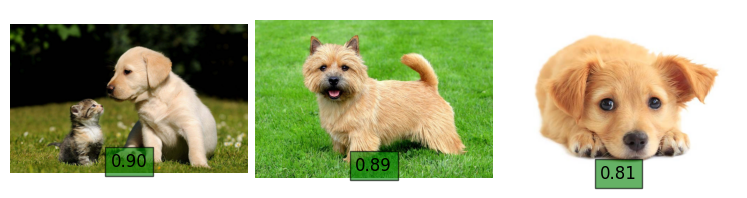

In [19]:
top_n = 3
image_urls = [x.input.data.image.url for x in search_response.hits][:top_n]
hit_scores = [x.score for x in search_response.hits][:top_n]
create_subplot(image_urls, hit_scores, num_rows=1, figsize=(10, 10))